In [10]:
import pandas as pd
import torchvision
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable
import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
import tqdm


In [11]:
from monai.transforms import Compose, LoadImaged,EnsureChannelFirstd,Spacingd, Orientationd, ScaleIntensityRanged, CropForegroundd, Resized, ToTensord


In [1]:
import monai.transforms as transforms
print(dir(transforms))



C:\Users\WILSONA\anaconda3\envs\monai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Activations', 'ActivationsD', 'ActivationsDict', 'Activationsd', 'AddCoordinateChannels', 'AddCoordinateChannelsD', 'AddCoordinateChannelsDict', 'AddCoordinateChannelsd', 'AddExtremePointsChannel', 'AddExtremePointsChannelD', 'AddExtremePointsChannelDict', 'AddExtremePointsChanneld', 'AdjustContrast', 'AdjustContrastD', 'AdjustContrastDict', 'AdjustContrastd', 'Affine', 'AffineD', 'AffineDict', 'AffineGrid', 'Affined', 'ApplyPending', 'ApplyPendingD', 'ApplyPendingDict', 'ApplyPendingd', 'AsChannelLast', 'AsChannelLastD', 'AsChannelLastDict', 'AsChannelLastd', 'AsDiscrete', 'AsDiscreteD', 'AsDiscreteDict', 'AsDiscreted', 'BatchInverseTransform', 'BorderPad', 'BorderPadD', 'BorderPadDict', 'BorderPadd', 'BoundingRect', 'BoundingRectD', 'BoundingRectDict', 'BoundingRectd', 'CastToType', 'CastToTypeD', 'CastToTypeDict', 'CastToTyped', 'CenterScaleCrop', 'CenterScaleCropD', 'CenterScaleCropDict', 'CenterScaleCropd', 'CenterSpatialCrop', 'CenterSpatialCropD', 'CenterSpatialCropDict', 'Cen

In [2]:
#data_dir= r'C:\Users\WILSONA\Desktop\Anything Python and  ML\PROJECTS DONE\MONAI...medical image 3 to 4D segmentation\08-3D-Liver-Tumor-Segmentation'

import os
import shutil
import random
from sklearn.model_selection import train_test_split

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def move_files(files, src_dir, dest_dir):
    for file_name in files:
        src_path = os.path.join(src_dir, file_name)
        dest_path = os.path.join(dest_dir, file_name)
        shutil.move(src_path, dest_path)

# Function to split data into 80-10-10 and save into folders
def split_data(volumes_dir, segmentations_dir, output_dir):
    # Get all volume files (assuming they match with segmentation files by name)
    all_volumes = os.listdir(volumes_dir)
    all_volumes.sort()  # Ensure consistent order
    all_segmentations = os.listdir(segmentations_dir)
    all_segmentations.sort()  # Ensure consistent order

    # Shuffle the files randomly to ensure a random split
    data_pairs = list(zip(all_volumes, all_segmentations))  # Pair volumes and segmentations
    random.shuffle(data_pairs)

    # Split into 80-10-10
    train_pairs, temp_pairs = train_test_split(data_pairs, test_size=0.2, random_state=42)  # 80% train
    validation_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)  # 10% validation, 10% test

    # Create destination directories for train, validation, and test splits
    train_vol_dir = os.path.join(output_dir, 'train', 'volumes')
    train_seg_dir = os.path.join(output_dir, 'train', 'segmentations')
    val_vol_dir = os.path.join(output_dir, 'validation', 'volumes')
    val_seg_dir = os.path.join(output_dir, 'validation', 'segmentations')
    test_vol_dir = os.path.join(output_dir, 'test', 'volumes')
    test_seg_dir = os.path.join(output_dir, 'test', 'segmentations')

    create_dir(train_vol_dir)
    create_dir(train_seg_dir)
    create_dir(val_vol_dir)
    create_dir(val_seg_dir)
    create_dir(test_vol_dir)
    create_dir(test_seg_dir)

    # Move the files to their respective folders
    for vol_file, seg_file in train_pairs:
        move_files([vol_file], volumes_dir, train_vol_dir)
        move_files([seg_file], segmentations_dir, train_seg_dir)

    for vol_file, seg_file in validation_pairs:
        move_files([vol_file], volumes_dir, val_vol_dir)
        move_files([seg_file], segmentations_dir, val_seg_dir)

    for vol_file, seg_file in test_pairs:
        move_files([vol_file], volumes_dir, test_vol_dir)
        move_files([seg_file], segmentations_dir, test_seg_dir)

    print("Data successfully split into train, validation, and test folders.")


volumes_directory = r'C:\Users\WILSONA\Desktop\Anything Python and  ML\PROJECTS DONE\MONAI...medical image 3 to 4D segmentation\08-3D-Liver-Tumor-Segmentation\images'  # Path to your images (volumes)
segmentations_directory = r'C:\Users\WILSONA\Desktop\Anything Python and  ML\PROJECTS DONE\MONAI...medical image 3 to 4D segmentation\08-3D-Liver-Tumor-Segmentation\labels'  # Path to your labels (segmentations)
output_directory = r'C:\Users\WILSONA\Desktop\Anything Python and  ML\PROJECTS DONE\MONAI...medical image 3 to 4D segmentation\08-3D-Liver-Tumor-Segmentation\split_data'  # Path where split data will be saved

# Call the function to split data
split_data(volumes_directory, segmentations_directory, output_directory)


import os
import gzip
import shutil
from glob import glob

def compress_and_replace_nifti_files(folder_path):
    # Print out the folder path for debugging
    print(f"Folder path: {folder_path}")

    # List all files in the directory for debugging
    all_files = os.listdir(folder_path)
    print(f"Files in the folder: {all_files}")

    # Search for all .nii files in the specified folder
    nii_files = glob(os.path.join(folder_path, '*.nii'))
    if not nii_files:
        print(f"No .nii files found in {folder_path}!")
    else:
        for file_path in nii_files:
            # Define the output path for the .nii.gz file
            gz_file_path = file_path + '.gz'
            # Compress the .nii file into .nii.gz
            with open(file_path, 'rb') as f_in:
                with gzip.open(gz_file_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)  # Copy the file content
            print(f"Compressed file: {gz_file_path}")

            # Remove the original .nii file
            os.remove(file_path)
            print(f"Deleted original file: {file_path}")

    print(f"All .nii files have been compressed to .nii.gz in {folder_path}!")

# Specify your folder path directly
folder_path = folder name 
# Call the function to compress .nii files in the specified folder
compress_and_replace_nifti_files(folder_path)


In [3]:
from glob import glob
import os
from monai.utils import set_determinism
set_determinism(seed=0)

In [4]:
from glob import glob

set_determinism(seed=0)
#in_dir =r'C:\Users\WILSONA\Desktop\Anything Python and  ML\PROJECTS DONE\MONAI...medical image 3 to 4D segmentation\08-3D-Liver-Tumor-Segmentation'

path_train_volumes = sorted(glob(os.path.join( "Trainvolumes", '*.nii.gz')))
path_train_segmentation = sorted(glob(os.path.join("TrainSegmentations", '*.nii.gz')))
path_valid_volumes = sorted(glob(os.path.join( "Validvolumes", '*.nii.gz')))
path_valid_segmentation = sorted(glob(os.path.join( "Validsegmentations", '*.nii.gz')))


In [5]:
from glob import glob

set_determinism(seed=0)
#in_dir = r"C:\Users\YourUsername\Desktop\Anything Python and ML\PROJECTS DONE\MONAI projects\08-3D-Liver-Tumor-Segmentation"

path_Train_volumes = sorted(glob(os.path.join( "Trainvolumes", '*.nii.gz')))
path_Train_segmentation = sorted(glob(os.path.join( "TrainSegmentations", '*.nii.gz')))

path_Valid_volumes = sorted(glob(os.path.join( "Validvolumes", '*.nii.gz')))
path_Valid_segmentation = sorted(glob(os.path.join( "Validsegmentations", '*.nii.gz')))

train_files = [{"vol":image_name,"seg":label_name} for image_name,label_name in zip(path_train_volumes,path_train_segmentation)]
valid_files = [{"vol":image_name,"seg":label_name} for image_name,label_name in zip(path_valid_volumes,path_valid_segmentation)]






In [6]:
from glob import glob
import os

path_train_volumes = sorted(glob(os.path.join( "Trainvolumes", '*.nii.gz')))
path_train_segmentation = sorted(glob(os.path.join( "TrainSegmentations", '*.nii.gz')))
path_valid_volumes = sorted(glob(os.path.join( "Validvolumes", '*.nii.gz')))
path_valid_segmentation = sorted(glob(os.path.join( "Validsegmentations", '*.nii.gz')))

print("Training Volumes:")
print(path_train_volumes)

print("\nTraining Segmentation:")
print(path_train_segmentation)

print("\nValidation Volumes:")
print(path_valid_volumes)

print("\nValidation Segmentation:")
print(path_valid_segmentation)


Training Volumes:
['Trainvolumes\\liver_0.nii.gz', 'Trainvolumes\\liver_10.nii.gz', 'Trainvolumes\\liver_101.nii.gz', 'Trainvolumes\\liver_102.nii.gz', 'Trainvolumes\\liver_104.nii.gz', 'Trainvolumes\\liver_106.nii.gz', 'Trainvolumes\\liver_107.nii.gz', 'Trainvolumes\\liver_109.nii.gz', 'Trainvolumes\\liver_11.nii.gz', 'Trainvolumes\\liver_111.nii.gz', 'Trainvolumes\\liver_112.nii.gz', 'Trainvolumes\\liver_113.nii.gz', 'Trainvolumes\\liver_115.nii.gz', 'Trainvolumes\\liver_116.nii.gz', 'Trainvolumes\\liver_117.nii.gz', 'Trainvolumes\\liver_118.nii.gz', 'Trainvolumes\\liver_119.nii.gz', 'Trainvolumes\\liver_120.nii.gz', 'Trainvolumes\\liver_121.nii.gz', 'Trainvolumes\\liver_122.nii.gz', 'Trainvolumes\\liver_125.nii.gz', 'Trainvolumes\\liver_126.nii.gz', 'Trainvolumes\\liver_127.nii.gz', 'Trainvolumes\\liver_128.nii.gz', 'Trainvolumes\\liver_13.nii.gz', 'Trainvolumes\\liver_14.nii.gz', 'Trainvolumes\\liver_15.nii.gz', 'Trainvolumes\\liver_16.nii.gz', 'Trainvolumes\\liver_18.nii.gz', 'Tra

In [7]:
# Print the contents of each list and their counts
print("Training Volumes:")
print(f"Count: {len(path_train_volumes)}")

print("\nTraining Segmentation:")
print(f"Count: {len(path_train_segmentation)}")

print("\nValidation Volumes:")
print(f"Count: {len(path_valid_volumes)}")

print("\nValidation Segmentation:")
print(f"Count: {len(path_valid_segmentation)}")


Training Volumes:
Count: 98

Training Segmentation:
Count: 98

Validation Volumes:
Count: 12

Validation Segmentation:
Count: 12


In [17]:
from glob import glob

set_determinism(seed=0)
#in_dir =r'C:\Users\WILSONA\Desktop\Anything Python and  ML\PROJECTS DONE\MONAI...medical image 3 to 4D segmentation\08-3D-Liver-Tumor-Segmentation'

path_train_volumes = sorted(glob(os.path.join( "Trainvolumes", '*.nii.gz')))
path_train_segmentation = sorted(glob(os.path.join( "TrainSegmentations", '*.nii.gz')))
path_valid_volumes = sorted(glob(os.path.join( "Validvolumes", '*.nii.gz')))
path_valid_segmentation = sorted(glob(os.path.join( "Validsegmentations", '*.nii.gz')))


In [18]:
from glob import glob
import os
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    ScaleIntensityRanged, CropForegroundd, Resized, ToTensord
)
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import set_determinism

set_determinism(seed=0)

# Create file dictionaries for train and validation data
train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
valid_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_valid_volumes, path_valid_segmentation)]

def prepare(pixdim=(1.5, 1.5, 1.0), a_min=200, a_max=200, spatial_size=[128, 128, 64], cache=False):
    train_transforms = Compose([
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["vol", "seg"], source_key="vol", allow_smaller=True),
        Resized(keys=["vol", "seg"], spatial_size=spatial_size),
        ToTensord(keys=["vol", "seg"]),
    ])

    valid_transforms = Compose([
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["vol", "seg"], source_key="vol", allow_smaller=True),
        Resized(keys=["vol", "seg"], spatial_size=spatial_size),
        ToTensord(keys=["vol", "seg"]),
    ])


In [19]:
def prepare(pixdim=(1.5, 1.5, 1.0), a_min=200, a_max=200, spatial_size=[128, 128, 64], cache=False):
    train_transforms = Compose([
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["vol", "seg"], source_key="vol", allow_smaller=True),
        Resized(keys=["vol", "seg"], spatial_size=spatial_size),
        ToTensord(keys=["vol", "seg"]),
    ])

    valid_transforms = Compose([
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["vol", "seg"], source_key="vol", allow_smaller=True),
        Resized(keys=["vol", "seg"], spatial_size=spatial_size),
        ToTensord(keys=["vol", "seg"]),
    ])

    return train_transforms, valid_transforms


In [20]:
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, ScaleIntensityRanged, CropForegroundd, Resized, ToTensord

def get_transforms(pixdim, a_min, a_max, spatial_size):
    train_transforms = Compose([
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["vol", "seg"], source_key="vol", allow_smaller=True),
        Resized(keys=["vol", "seg"], spatial_size=spatial_size),
        ToTensord(keys=["vol", "seg"]),
    ])

    valid_transforms = Compose([
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["vol", "seg"], source_key="vol", allow_smaller=True),
        Resized(keys=["vol", "seg"], spatial_size=spatial_size),
        ToTensord(keys=["vol", "seg"]),
    ])

    return train_transforms, valid_transforms


In [22]:
from monai.data import CacheDataset, Dataset, DataLoader
def prepare_data(train_files, valid_files, train_transforms, valid_transforms, cache=False, batch_size=1):
    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=batch_size)

        valid_ds = CacheDataset(data=valid_files, transform=valid_transforms, cache_rate=1.0)
        valid_loader = DataLoader(valid_ds, batch_size=batch_size)
    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=batch_size)

        valid_ds = Dataset(data=valid_files, transform=valid_transforms)
        valid_loader = DataLoader(valid_ds, batch_size=batch_size)

    return train_loader, valid_loader



In [24]:
train_transforms, valid_transforms = prepare()


In [25]:
train_loader, valid_loader = prepare_data(train_files, valid_files, train_transforms, valid_transforms, cache=False)


In [26]:
train_loader, valid_loader = prepare_data(train_files, valid_files, train_transforms, valid_transforms, cache=False)


## visualising one of the slices in 2D...WANTED TO CHECK OUT SOMETHING

In [45]:
import matplotlib.pyplot as plt
from monai.utils import first
def visualize_sample(data_loader, slice_number=0):
    sample = first(data_loader)
    
    # Extract the volume and segmentation from the sample
    volume = sample["vol"][0, 0]  # [batch, channel, height, width, depth] -> take first batch, first channel
    segmentation = sample["seg"][0, 0]  # [batch, channel, height, width, depth] -> take first batch, first channel

    # Plot the specified slice from the volume and segmentation
    plt.figure(figsize=(12, 6))

    # Show the volume slice
    plt.subplot(1, 2, 1)
    plt.title(f"Volume - Slice {slice_number}")
    plt.imshow(volume[:, :, slice_number].detach().cpu().numpy(), cmap="gray")

    # Show the segmentation slice
    plt.subplot(1, 2, 2)
    plt.title(f"Segmentation - Slice {slice_number}")
    plt.imshow(segmentation[:, :, slice_number].detach().cpu().numpy(), cmap="gray")

    plt.show()

visualize_sample(train_loader, slice_number=32)  


TypeError: 'Compose' object is not iterable

In [46]:
from monai.utils import first

def show_patient(data, slice_number=1, mode="train"):
    train_loader, valid_loader = data
    data_loader = train_loader if mode == "train" else valid_loader
    view_patient = first(data_loader)  # Fetch first batch from DataLoader

    # Verify slice_number is within bounds
    num_slices = view_patient["vol"].shape[-1]
    if slice_number >= num_slices or slice_number < 0:
        raise ValueError(f"slice_number {slice_number} is out of range. Must be between 0 and {num_slices - 1}.")

    # Set up the figure
    plt.figure(f"Visualization {mode.capitalize()}", (12, 6))
    
    # Display volume slice
    plt.subplot(1, 2, 1)
    plt.title(f"vol {slice_number}")
    plt.imshow(view_patient["vol"][0, 0, :, :, slice_number], cmap="gray")

    # Display segmentation slice
    plt.subplot(1, 2, 2)
    plt.title(f"seg {slice_number}")
    plt.imshow(view_patient["seg"][0, 0, :, :, slice_number])
    
    plt.show()


C:\Users\WILSONA\anaconda3\envs\monai\lib\site-packages\monai\transforms\intensity\array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


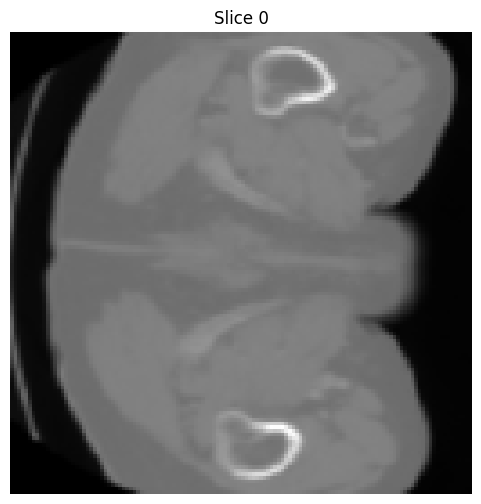

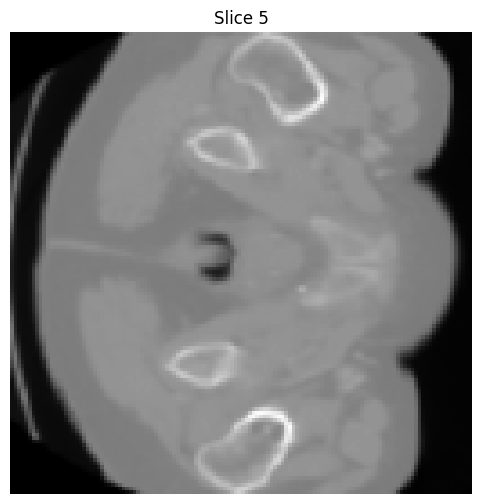

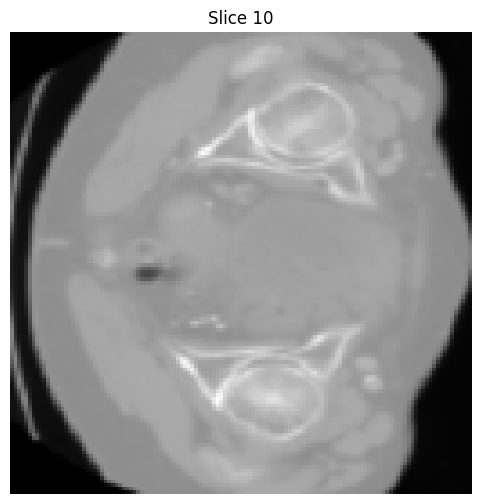

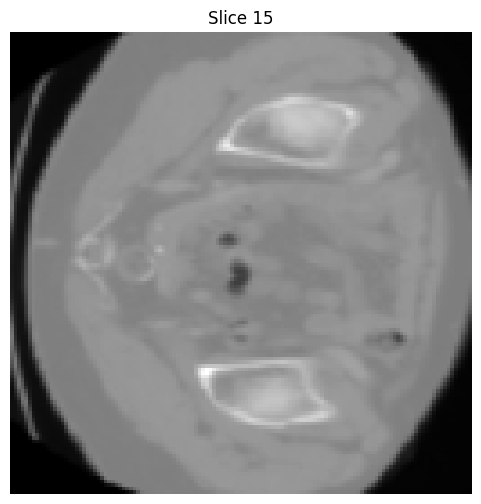

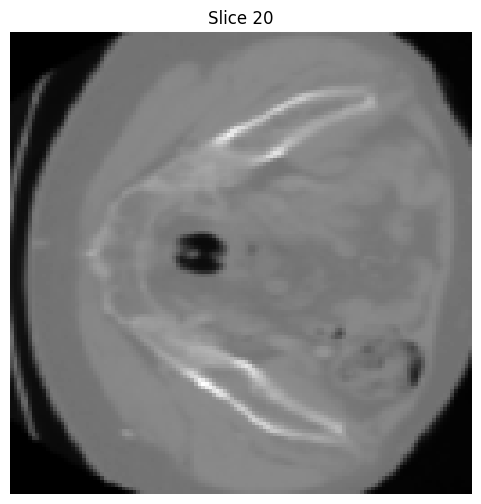

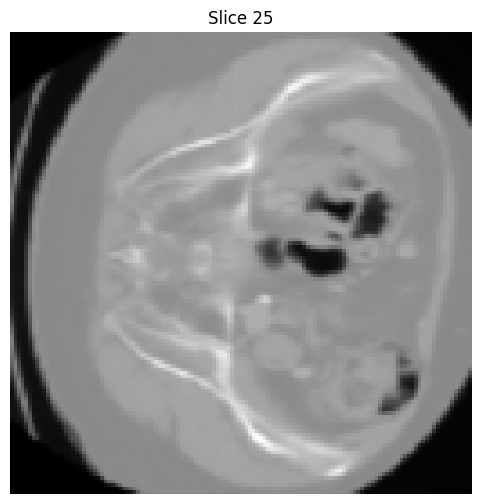

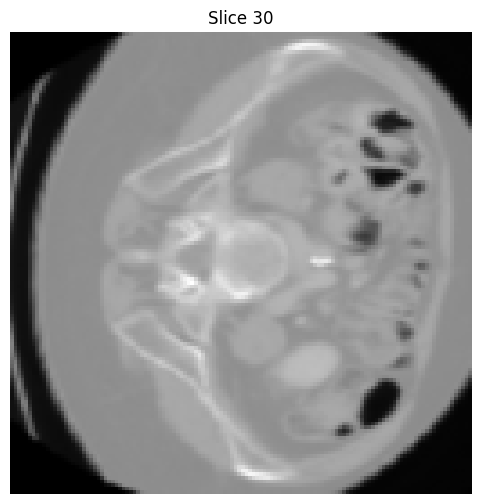

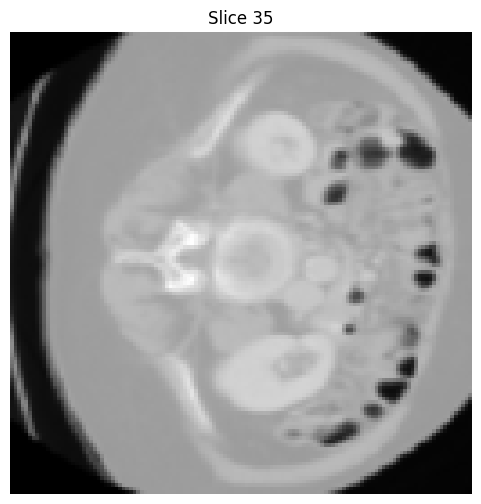

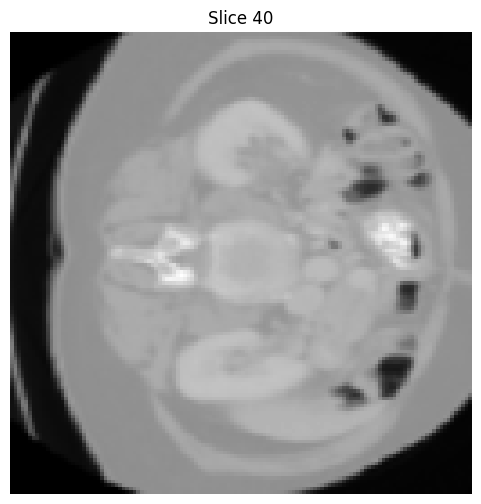

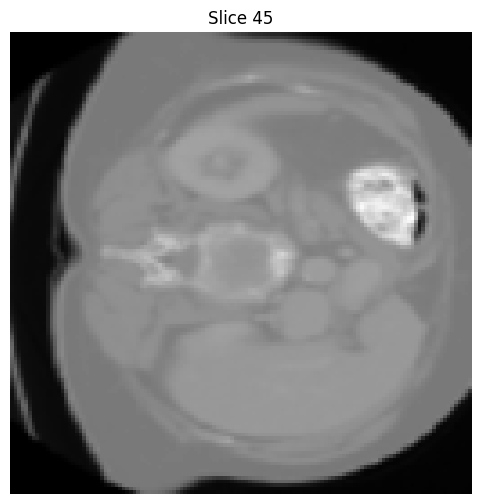

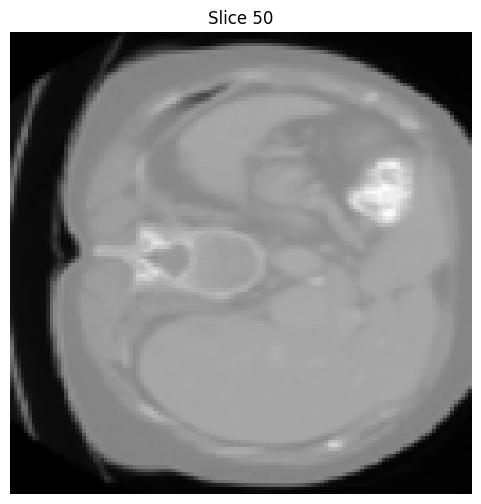

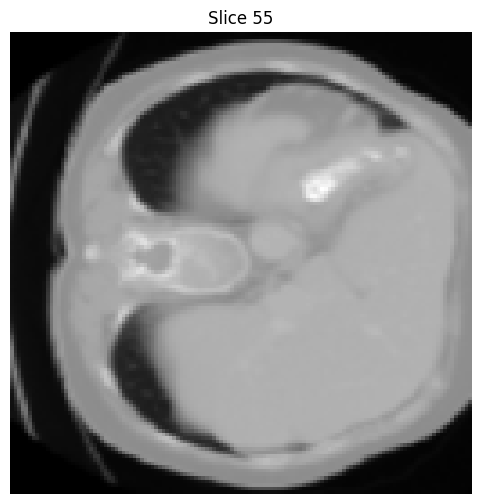

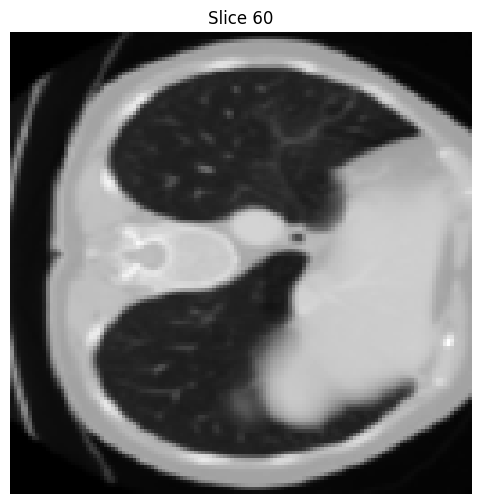

In [27]:
import matplotlib.pyplot as plt
from monai.utils import first
import torch

def visualize_3d_sample(data_loader):
    
    sample = first(data_loader)
    
    # Extract the volume from the sample
    volume = sample["vol"][0, 0]  # [batch, channel, height, width, depth] -> take first batch, first channel
    depth = volume.shape[-1]  # Depth of the 3D volume

    # Plot slices of the 3D volume
    for i in range(0, depth, 5):  # Visualize every 5th slice
        plt.figure(figsize=(6, 6))
        plt.title(f"Slice {i}")
        plt.imshow(volume[:, :, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
        plt.show()
visualize_3d_sample(train_loader)


In [28]:
print(f"Train Volumes: {len(path_train_volumes)}")
print(f"Train Segmentations: {len(path_train_segmentation)}")
print(f"Valid Volumes: {len(path_valid_volumes)}")
print(f"Valid Segmentations: {len(path_valid_segmentation)}")


Train Volumes: 98
Train Segmentations: 98
Valid Volumes: 12
Valid Segmentations: 12


In [29]:
#train_loader, valid_loader = prepare(cache=True)  # Set cache=True if you want caching


In [30]:
# Check a few samples from the train loader
for i, batch in enumerate(train_loader):
    vol = batch["vol"]
    seg = batch["seg"]
    print(f"Batch {i+1}:")
    print(f"Volume shape: {vol.shape}")
    print(f"Segmentation shape: {seg.shape}")
    
    if i == 0:  # Stop after the first batch
        break

# Similarly, check the valid_loader
for i, batch in enumerate(valid_loader):
    vol = batch["vol"]
    seg = batch["seg"]
    print(f"Validation Batch {i+1}:")
    print(f"Volume shape: {vol.shape}")
    print(f"Segmentation shape: {seg.shape}")
    
    if i == 0:  # Stop after the first batch
        break


Batch 1:
Volume shape: torch.Size([1, 1, 128, 128, 64])
Segmentation shape: torch.Size([1, 1, 128, 128, 64])
Validation Batch 1:
Volume shape: torch.Size([1, 1, 128, 128, 64])
Segmentation shape: torch.Size([1, 1, 128, 128, 64])


Train sample keys: dict_keys(['vol', 'seg', 'foreground_start_coord', 'foreground_end_coord'])
Test sample keys: dict_keys(['vol', 'seg', 'foreground_start_coord', 'foreground_end_coord'])


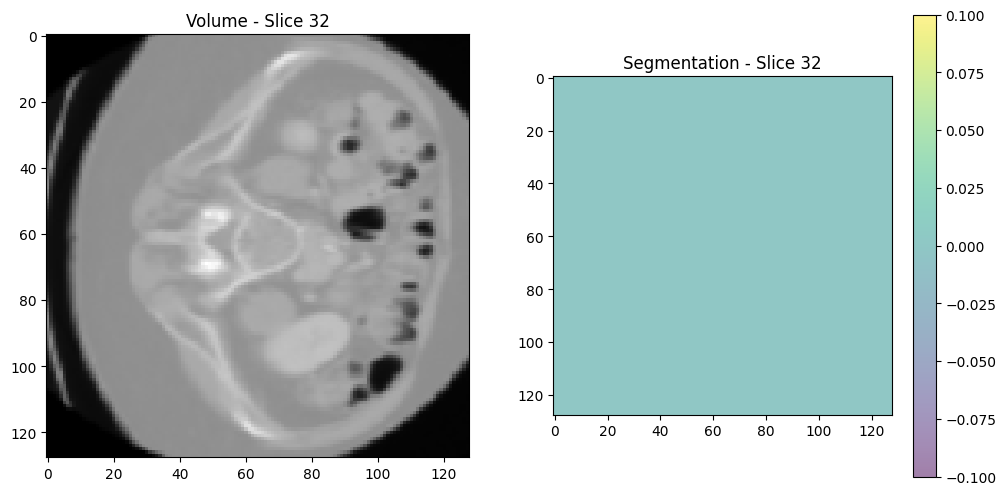

In [55]:
# Get only the transformations from prepare
train_transforms, valid_transforms = prepare()

# Create DataLoaders using the `prepare_data` function
train_loader, valid_loader = prepare_data(train_files, valid_files, train_transforms, valid_transforms, cache=False)

# Now visualize using the `show_patient` function
show_patient((train_loader, valid_loader), SLICE_NUMBER=32, train=True, test=False)


In [ ]:
import matplotlib.pyplot as plt
from monai.utils import first

def show_patient_overlay(data, SLICE_NUMBER=1, train=True, test=False):
    """
    Visualizes the volume slice with segmentation overlay.
    `data`: tuple of (train_loader, valid_loader)
    `SLICE_NUMBER`: The index of the slice to visualize
    `train`: If True, visualizes a sample from the training loader
    `test`: If True, visualizes a sample from the validation loader
    """

    # Unpack the data loaders
    train_loader, valid_loader = data
    
    # Retrieve first patient from train or validation loader
    train_sample = first(train_loader) if train else None
    valid_sample = first(valid_loader) if test else None

    # Define a helper function for visualization
    def plot_overlay(patient_sample, slice_number, title="Sample"):
        if patient_sample is None:
            print("No patient data available for visualization.")
            return
        
        # Extract volume and segmentation slices
        volume_slice = patient_sample["vol"][0, 0, :, :, slice_number].detach().cpu().numpy()
        segmentation_slice = patient_sample["seg"][0, 0, :, :, slice_number].detach().cpu().numpy()

        # Display the overlay
        plt.figure(figsize=(10, 5))
        plt.title(f"{title} - Slice {slice_number}")
        plt.imshow(volume_slice, cmap="gray")
        plt.imshow(segmentation_slice, cmap="jet", alpha=0.5)  # Use `alpha` for transparency
        plt.colorbar(label="Segmentation Overlay", orientation="vertical")
        plt.axis("off")
        plt.show()

    # Visualize the train sample
    if train:
        plot_overlay(train_sample, SLICE_NUMBER, title="Train Data")

    # Visualize the validation sample
    if test:
        plot_overlay(valid_sample, SLICE_NUMBER, title="Validation Data")

# Usage Example
show_patient_overlay((train_loader, valid_loader), SLICE_NUMBER=32, train=True, test=False)


In [34]:
import monai
print(monai.__version__)


1.3.2


In [32]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
from monai.losses import DiceLoss, DiceCELoss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    spatial_dims=3
).to(device)


from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch
from preprocess import prepare
from utilities import train


model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()


In [36]:
from monai.losses import DiceLoss
from torch.optim import Adam

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), lr=0.00004)


In [24]:
import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet  # Example model
from monai.utils import set_determinism
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


In [49]:
import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet  # Example model
from monai.utils import set_determinism

In [50]:
UNet_meatdata = {
    "spatial_dims": 3,
    "in_channels": 1,
    "out_channels": 2,
    "channels": (16, 32, 64, 128, 256),
    "strides": (2, 2, 2, 2),
    "num_res_units": 2,
    "norm": Norm.BATCH,
}

model = UNet(**UNet_meatdata).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

In [25]:
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [39]:
import matplotlib.pyplot as plt

num_epochs = 10  
train_losses = []
valid_losses = []  

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    # Training step
    for batch_data in train_loader:
        inputs, labels = batch_data["vol"].to(device), batch_data["seg"].to(device)

        optimizer.zero_grad()  
        outputs = model(inputs)  
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # Store training loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation step
    model.eval()  
    val_running_loss = 0.0
    dice_score = 0.0
    with torch.no_grad():
        for val_data in valid_loader:
            val_inputs, val_labels = val_data["vol"].to(device), val_data["seg"].to(device)
            val_outputs = model(val_inputs)  

            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

            # Calculate Dice score
            dice_metric(y_pred=val_outputs, y=val_labels)
            dice_score += dice_metric.aggregate().item()

        val_epoch_loss = val_running_loss / len(valid_loader)
        avg_dice_score = dice_score / len(valid_loader)

        valid_losses.append(val_epoch_loss)  # Store validation loss
        print(f"Validation Loss: {val_epoch_loss:.4f}, Average Dice Score: {avg_dice_score:.4f}")

        # Reset the metric for the next epoch
        dice_metric.reset()

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


RuntimeError: index 2 is out of bounds for dimension 1 with size 2